In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Baseline Classification Pipeline

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("./data/ECG/ECG200_TRAIN.txt", sep='\s+', header=None)

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,-1.0,0.502055,0.542163,0.722383,1.428885,2.136516,2.281149,1.936274,1.468890,1.008845,...,0.931043,0.610298,0.638894,0.684679,0.583238,0.640522,0.708585,0.705011,0.713815,0.433765
1,1.0,0.147647,0.804668,0.367771,0.243894,0.026614,-0.274402,0.096731,-0.747731,-1.609777,...,-0.533503,-0.400228,0.176084,1.111768,2.438428,2.734889,1.736054,0.036857,-1.265074,-0.208024
2,-1.0,0.316646,0.243199,0.370471,1.063738,1.678187,1.759558,1.697717,1.612159,1.168188,...,0.764229,0.610621,0.552900,0.566786,0.604002,0.777068,0.812345,0.748848,0.818042,0.539347
3,-1.0,1.168874,2.075901,1.760140,1.606446,1.949046,1.302842,0.459332,0.516412,0.852180,...,0.419006,0.723888,1.323947,2.136488,1.746597,1.470220,1.893512,1.256949,0.800407,0.731540
4,1.0,0.648658,0.752026,2.636231,3.455716,2.118157,0.520620,-0.188627,0.780818,0.933775,...,-0.097869,-0.136787,-0.340237,-0.089441,-0.080297,-0.192584,-0.304704,-0.454556,0.314590,0.582190


### Target : negative and positive examples

In [5]:
set(df[0])

{-1.0, 1.0}

### Negative exmple

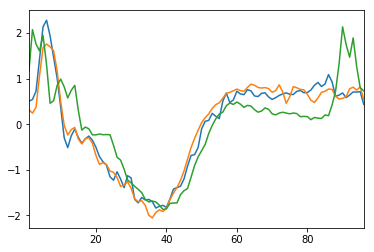

In [9]:
df.iloc[0,1:].plot();
df.iloc[2,1:].plot();
df.iloc[3,1:].plot();

### Posistive example

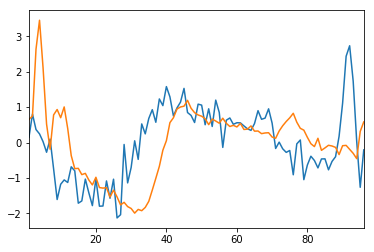

In [8]:
df.iloc[1,1:].plot();
df.iloc[4,1:].plot();
# сгладить скользящее среднее
# двустороннее
#

#### Goal: Build a classification model (labels are in column 0) against all features.


## Steps

1. Smoothen / filter / denoising ==> Get rid of randomly looking peaks.
    - Moving average. 
    - Percent change. 
    - Exponential smoothing.
    - Cumsum (basically the integral).
    - **Savitzky-Golay filter** ==> Approximating by polynomials in a small window.
    - **Fourier transform** ==> Series that look a little bit periodic.
    
2. Feature selection: Choose some features, either manually or algorithmically.
    - peakfinder functions: find local (within a given window) maxima/minima.
    - select features using a black-box optimization algorithm.
    - Backward/forward feature selection.
3. Create model by "normal" machine learning methods.

4. Why usual scaling could be bad in this case
    - Important moments and noise are on the same scale
    - Makes scense only to shift everything to zero
![](bad_scaling.png)

In [10]:
df.shape

(100, 97)

# Baseline exampe

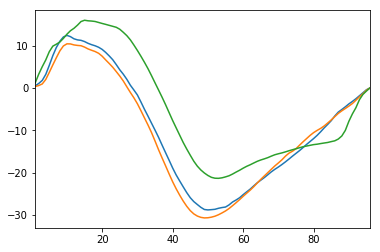

In [13]:
df.iloc[0,1:].cumsum().plot();
df.iloc[2,1:].cumsum().plot();
df.iloc[3,1:].cumsum().plot();

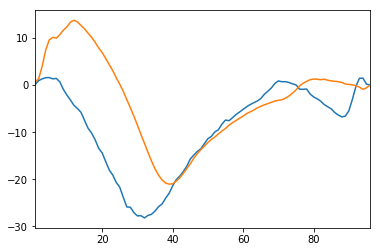

In [14]:
df.iloc[1,1:].cumsum().plot();
df.iloc[4,1:].cumsum().plot();

In [15]:
X = df.iloc[:,1:]

In [16]:
y = df.iloc[:,0]

In [17]:
from sklearn.feature_selection import SelectKBest # Replace by some peakfinder/blackbox method
# Other estimators can work well => decision trees / RF usually bad choices in this case
from sklearn.linear_model import LogisticRegression 
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [18]:
sel = SelectKBest(k=10)
clf = LogisticRegression(solver='lbfgs')
pipe = make_pipeline(sel, clf)

In [19]:
cross_val_score(pipe, X, y, cv=5, scoring='accuracy').mean()

0.8083208020050124

In [20]:
cross_val_score(pipe, X.cumsum(axis=1), y, cv=5, scoring='accuracy').mean()

0.8202756892230576

## PCA

In [21]:
from sklearn.decomposition import PCA
pca = PCA()

In [22]:
X_pca = pca.fit_transform(df.iloc[:,1:].values)

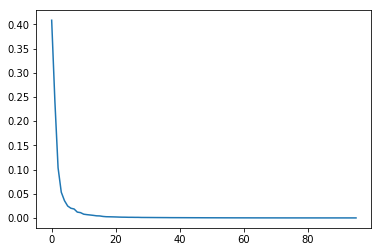

In [24]:
plt.plot(pca.explained_variance_ratio_);
# plt.hist(pca.explained_variance_ratio_, bins=50);

### Preprocessing methods

**Savitzky–Golay** filter is a digital filter that can be applied to a set of digital data points for the purpose of smoothing the data, that is, to increase the precision of the data without distorting the signal tendency.

In [25]:
from scipy.signal import savgol_filter

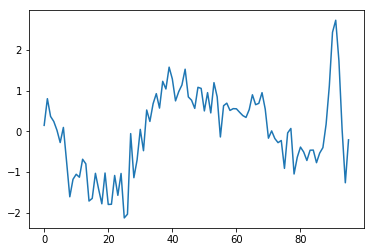

In [26]:
normal = df.iloc[1,1:].values
plt.plot(normal);

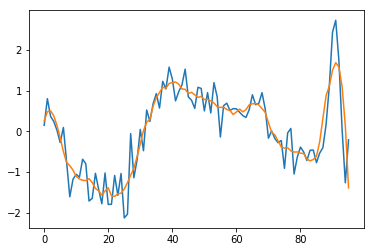

In [29]:
normal_smooth = savgol_filter(normal, window_length=5, polyorder=3)
plt.plot(normal);
plt.plot(normal_smooth);

#### Fourier Transform

/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


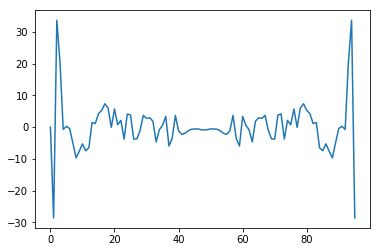

In [30]:
from scipy.fftpack import fft
fft_vals = fft(normal)
plt.plot(fft_vals);

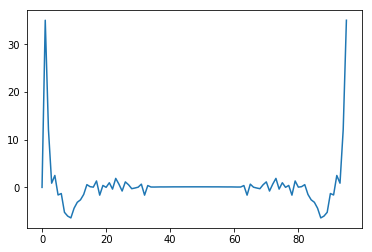

In [31]:
event = df.iloc[0,1:].values
fft_vals = fft(event)
plt.plot(fft_vals);

#### Power Spectral Density

/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))


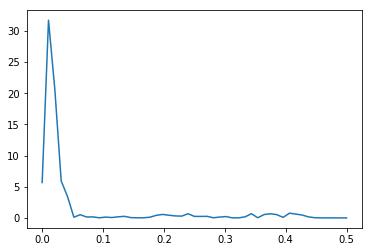

In [32]:
from scipy.signal import welch
vals, psd = welch(normal)
plt.plot(vals, psd);

## TO DO:
- Look at dependence of number of features vs accuracy.
- Look at feature importance against two representatives of each class.